In [1]:
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import sys
import numpy as np

# Plot settings
#from matplotlib import rc
#rc('text', usetex=True)
plt.rc('grid', linestyle="-")

# Paths
MODCELL2_PATH = os.environ["MODCELL2_PATH"] # Define as needed
directory='samples' # Note that sample data is available on https://github.com/trinhlab/modcell2-milp-sample-data

In [2]:
def get_samples(target_rxn):    
    file_paths = [os.path.join(directory, filename) for filename in os.listdir(directory) if filename.endswith(".csv")]
    samples = {}
    for filename in os.listdir(directory):
        if filename.endswith(".csv"):
            df = pd.read_csv(os.path.join(directory, filename), header=None)
            df.set_index([0], inplace=True)
            if target_rxn in df.index:
                # perform scaling: divide by s.u.r. and then by the maximum value across all networks. 
                samples[filename[:-4]] = (df.loc[target_rxn]/10)
            else:
                # The reaction is blocked for that particular network, usually this reactions are zero but that might not always be true, so their value needs to be read from a file
                samples[filename[:-4]] = 0 # READ FIXED FLUX FILE
    return samples
        
def plot_box(sample,ax):
    #ax.violinplot([v for k,v in sample.items()], vert=True);
    sns.violinplot(data=pd.DataFrame(sample), orient='h',palette=sns.color_palette("husl", 20),ax=ax)
        

In [3]:
# Target reactions and formatting features.
colors=dict(c=(53,174,151), o=(235,128,50), g=(113,172,49), b=(99,157,244), p=(180,134,244),m=(212,0,0))
colors={k:tuple([_/255 for _ in v]) for k,v in colors.items()}
all_rxns = dict(SUCCtex='o',
               MDH='o',
                FUM='o',
               PYRt2rpp='g',
               ACLS='g',
               ALCD2x='g',
               ETOHtex='g',
               LDH_D='g',
               POR5='b',
               THD2pp='b',
               ATPS4rpp='b',
               PFL='p',
               ACtex='g',
               PTAr='g',
               PDH='p',
               ECOAH1='g',
               ASPTA='c',
               ASPT='c',
               GLUDy='c',
               SUCOAS='c',
               PPC='c',
               MMCD='c')

module_reactions=[ # Very stiff
        'THD2pp',
    'LDH_D',
    'ALCD2x',
    'ETOHtex',
    'FUM',
    'PTAr' # may need ACKr?
]
not_interesting = []
not_sampled=['EX_pyr_e']
print('# of reactions:',len(all_rxns.keys()))

# Mappint id 2 name
id2namedf = pd.read_csv(f'{MODCELL2_PATH}/problems/ecoli-gem/id2name.csv')
id2name = dict(zip(id2namedf['id'],id2namedf['name']))

# of reactions: 22


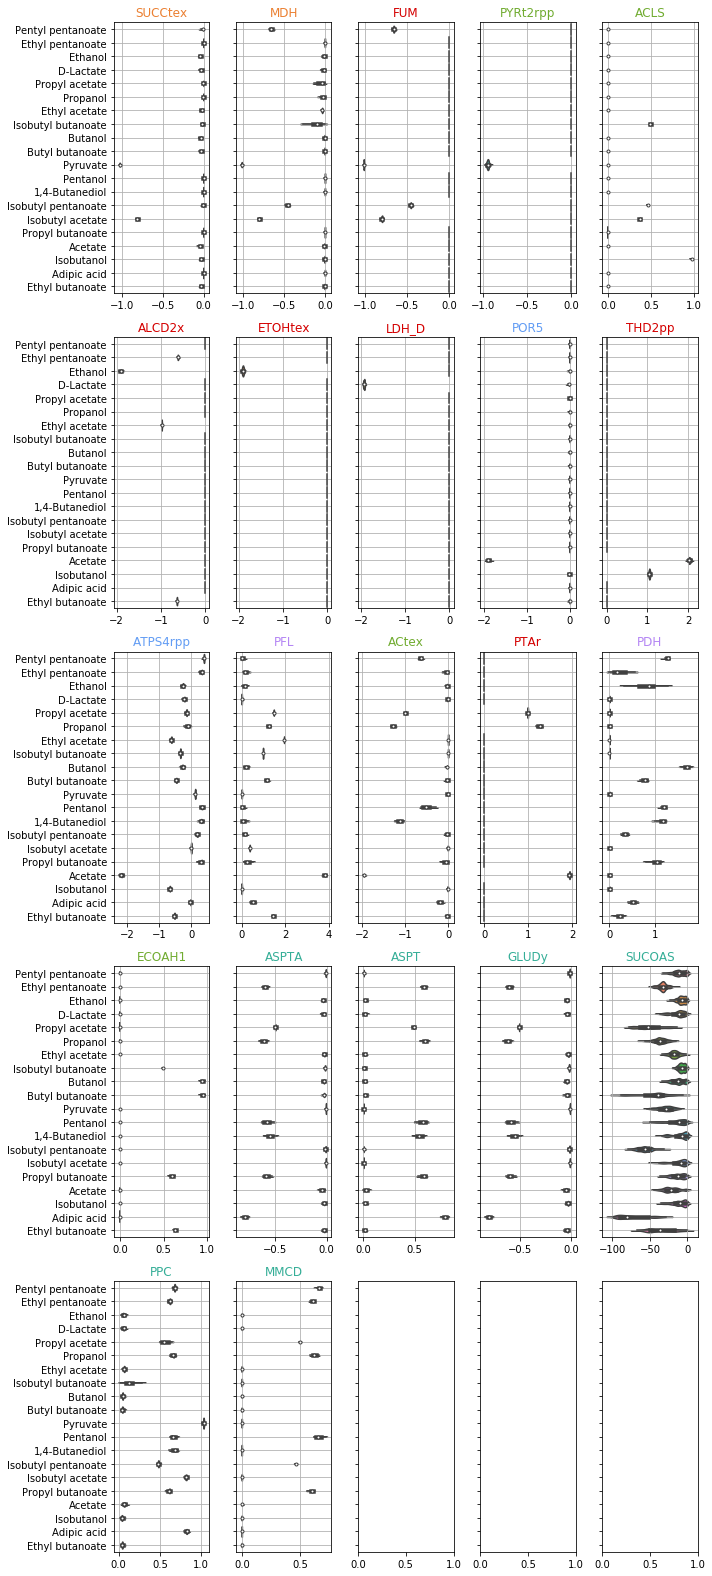

In [4]:
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=[10, 22], sharey='row')
for idx, target_rxn in enumerate(all_rxns.keys()):
    sample = get_samples(target_rxn)
    sample = {id2name[k]:v for k,v in sample.items()}
    ax = axes.flatten()[idx]
    plot_box(sample,ax)
    ax.title.set_text(target_rxn)
    ax.title.set_color(colors[all_rxns[target_rxn]])
    if target_rxn in module_reactions:
        ax.title.set_color(colors['m'])
    ax.grid(True)

plt.tight_layout()  
fig.savefig('dgrid.svg')

# Target reaction

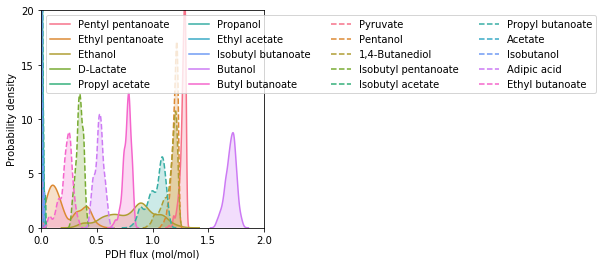

In [5]:
target_rxn = 'PDH'
sample = get_samples(target_rxn)
sample = {id2name[k]:v for k,v in sample.items()}

# Define line styles
col = sns.color_palette("husl", 10)
colors = dict(zip(sample.keys(),col+col))
lines = dict(zip(sample.keys(), ['-']*10 + ['--']*10))


# Graphing functions
def plot_target(samples,ax):
    for k,v in samples.items():
        try:
            sns.distplot(v, hist=False, ax=ax, kde_kws={"color": colors[k], "ls": lines[k], "shade": True}, label=k)   
            #lc = list(colors[k])
            #lc.append(0.6) # Add alpha
            #kde_x, kde_y = ax.lines[0].get_data()
            #ax.fill_between(kde_x, kde_y, color=tuple(lc))
        except error:
            raise(error)
            print('production module {} not included due to:{}'.format(k,sys.exc_info()[0])) # e.g. the reaction is always 0



# Generate plot
fig, ax = plt.subplots(figsize=[4,4])

plot_target(sample, ax)

# Adjust to current reaction
ax.set_ylim(bottom=0, top=20) # Cut very high peaks
ax.set_xlim(left=0, right=2) # If current reaction is irreversible
#ax.set_xticks([0,0.5,1,1.5,2])

ax.xaxis.set_label_text('{} flux (mol/mol)'.format(target_rxn))
ax.yaxis.set_label_text('Probability density')
plt.locator_params(axis='both', nbins=4)
lgd = plt.legend(ncol=4)
plt.savefig('one_rxn-{}.svg'.format(target_rxn),bbox_extra_artists=(lgd,), bbox_inches='tight')

In [6]:
# Unused
def plot_norm(sample, ax):
    n_bins = 50
    # get the histogram values
    for k,v in sample.items():
        heights,edges = np.histogram(v, bins=n_bins)
        binCenters = (edges[:-1] + edges[1:])/2
        # norm the heights
        heights = heights/heights.sum()
        ax.plot(binCenters, heights, label=k, color=colors[k],linestyle=lines[k])

## Plot of single reaction and network

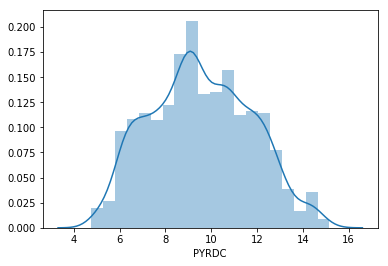

In [7]:
df = pd.read_csv('samples/etoh_pdc.csv', header=None)
df.set_index([0], inplace=True)
sns.distplot(df.loc['PYRDC',:])

### Pairwise comparison of target reaction

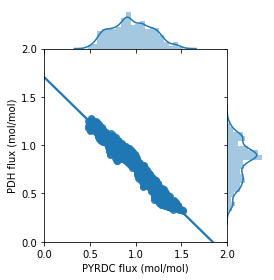

In [8]:
ndf = df/df.loc['EX_glc__D_e',:].abs()
g = sns.jointplot(x=ndf.loc['PYRDC',:], y=ndf.loc['PDH',:], data=df, kind="reg", space=0, height=4, xlim=(0,2), ylim=(0,2))
g.set_axis_labels('PYRDC flux (mol/mol)', "PDH flux (mol/mol)")
g.ax_joint.set_xticks([0, .5, 1, 1.5, 2])
g.ax_joint.set_yticks([0, .5, 1, 1.5, 2])
plt.savefig('etoh_pdhvspdc.svg')

# Below is testing
---

## Within one network

In [9]:
directory='samples'
target_rxn='PFL'
file_paths = [os.path.join(directory, filename) for filename in os.listdir(directory) if filename.endswith(".csv")]
samples = {}
for filename in os.listdir(directory):
    if filename.endswith(".csv"):
        df = pd.read_csv(os.path.join(directory, filename), header=None)
        df.set_index([0], inplace=True)
        # perform scaling: divide by s.u.r. and then by the maximum value across all networks. 
        samples[filename[:-4]] = (df.loc[target_rxn]/10)
        

In [10]:
# Create linestyle and color setup:
#[line.set_linestyle("--") for line in ax.lines]

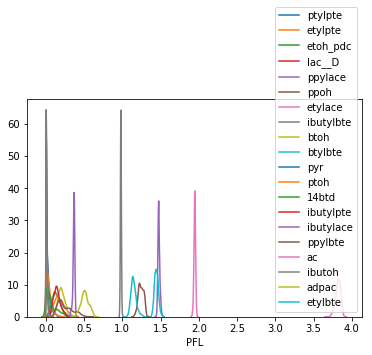

In [11]:
fig = plt.figure(figsize=[6, 4])
ax = plt.gca()
for k,v in samples.items():
    try:
        sns.distplot(v, hist=False, label=k, ax=ax, norm_hist=False)
    except:
        print('production module {} not included due to:{}'.format(k,sys.exc_info()[0])) # e.g. the reaction is always 0
plt.savefig('pfl_.svg')

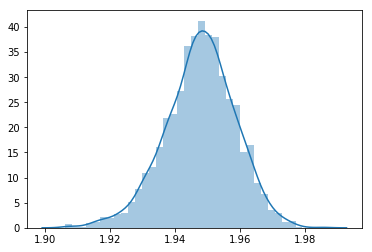

In [12]:
x = np.array(samples['etylace'])
ax = sns.distplot(x,hist=True,norm_hist=True, hist_kws={'density':True})
#ax = sns.distplot(x,hist=False,ax=ax)

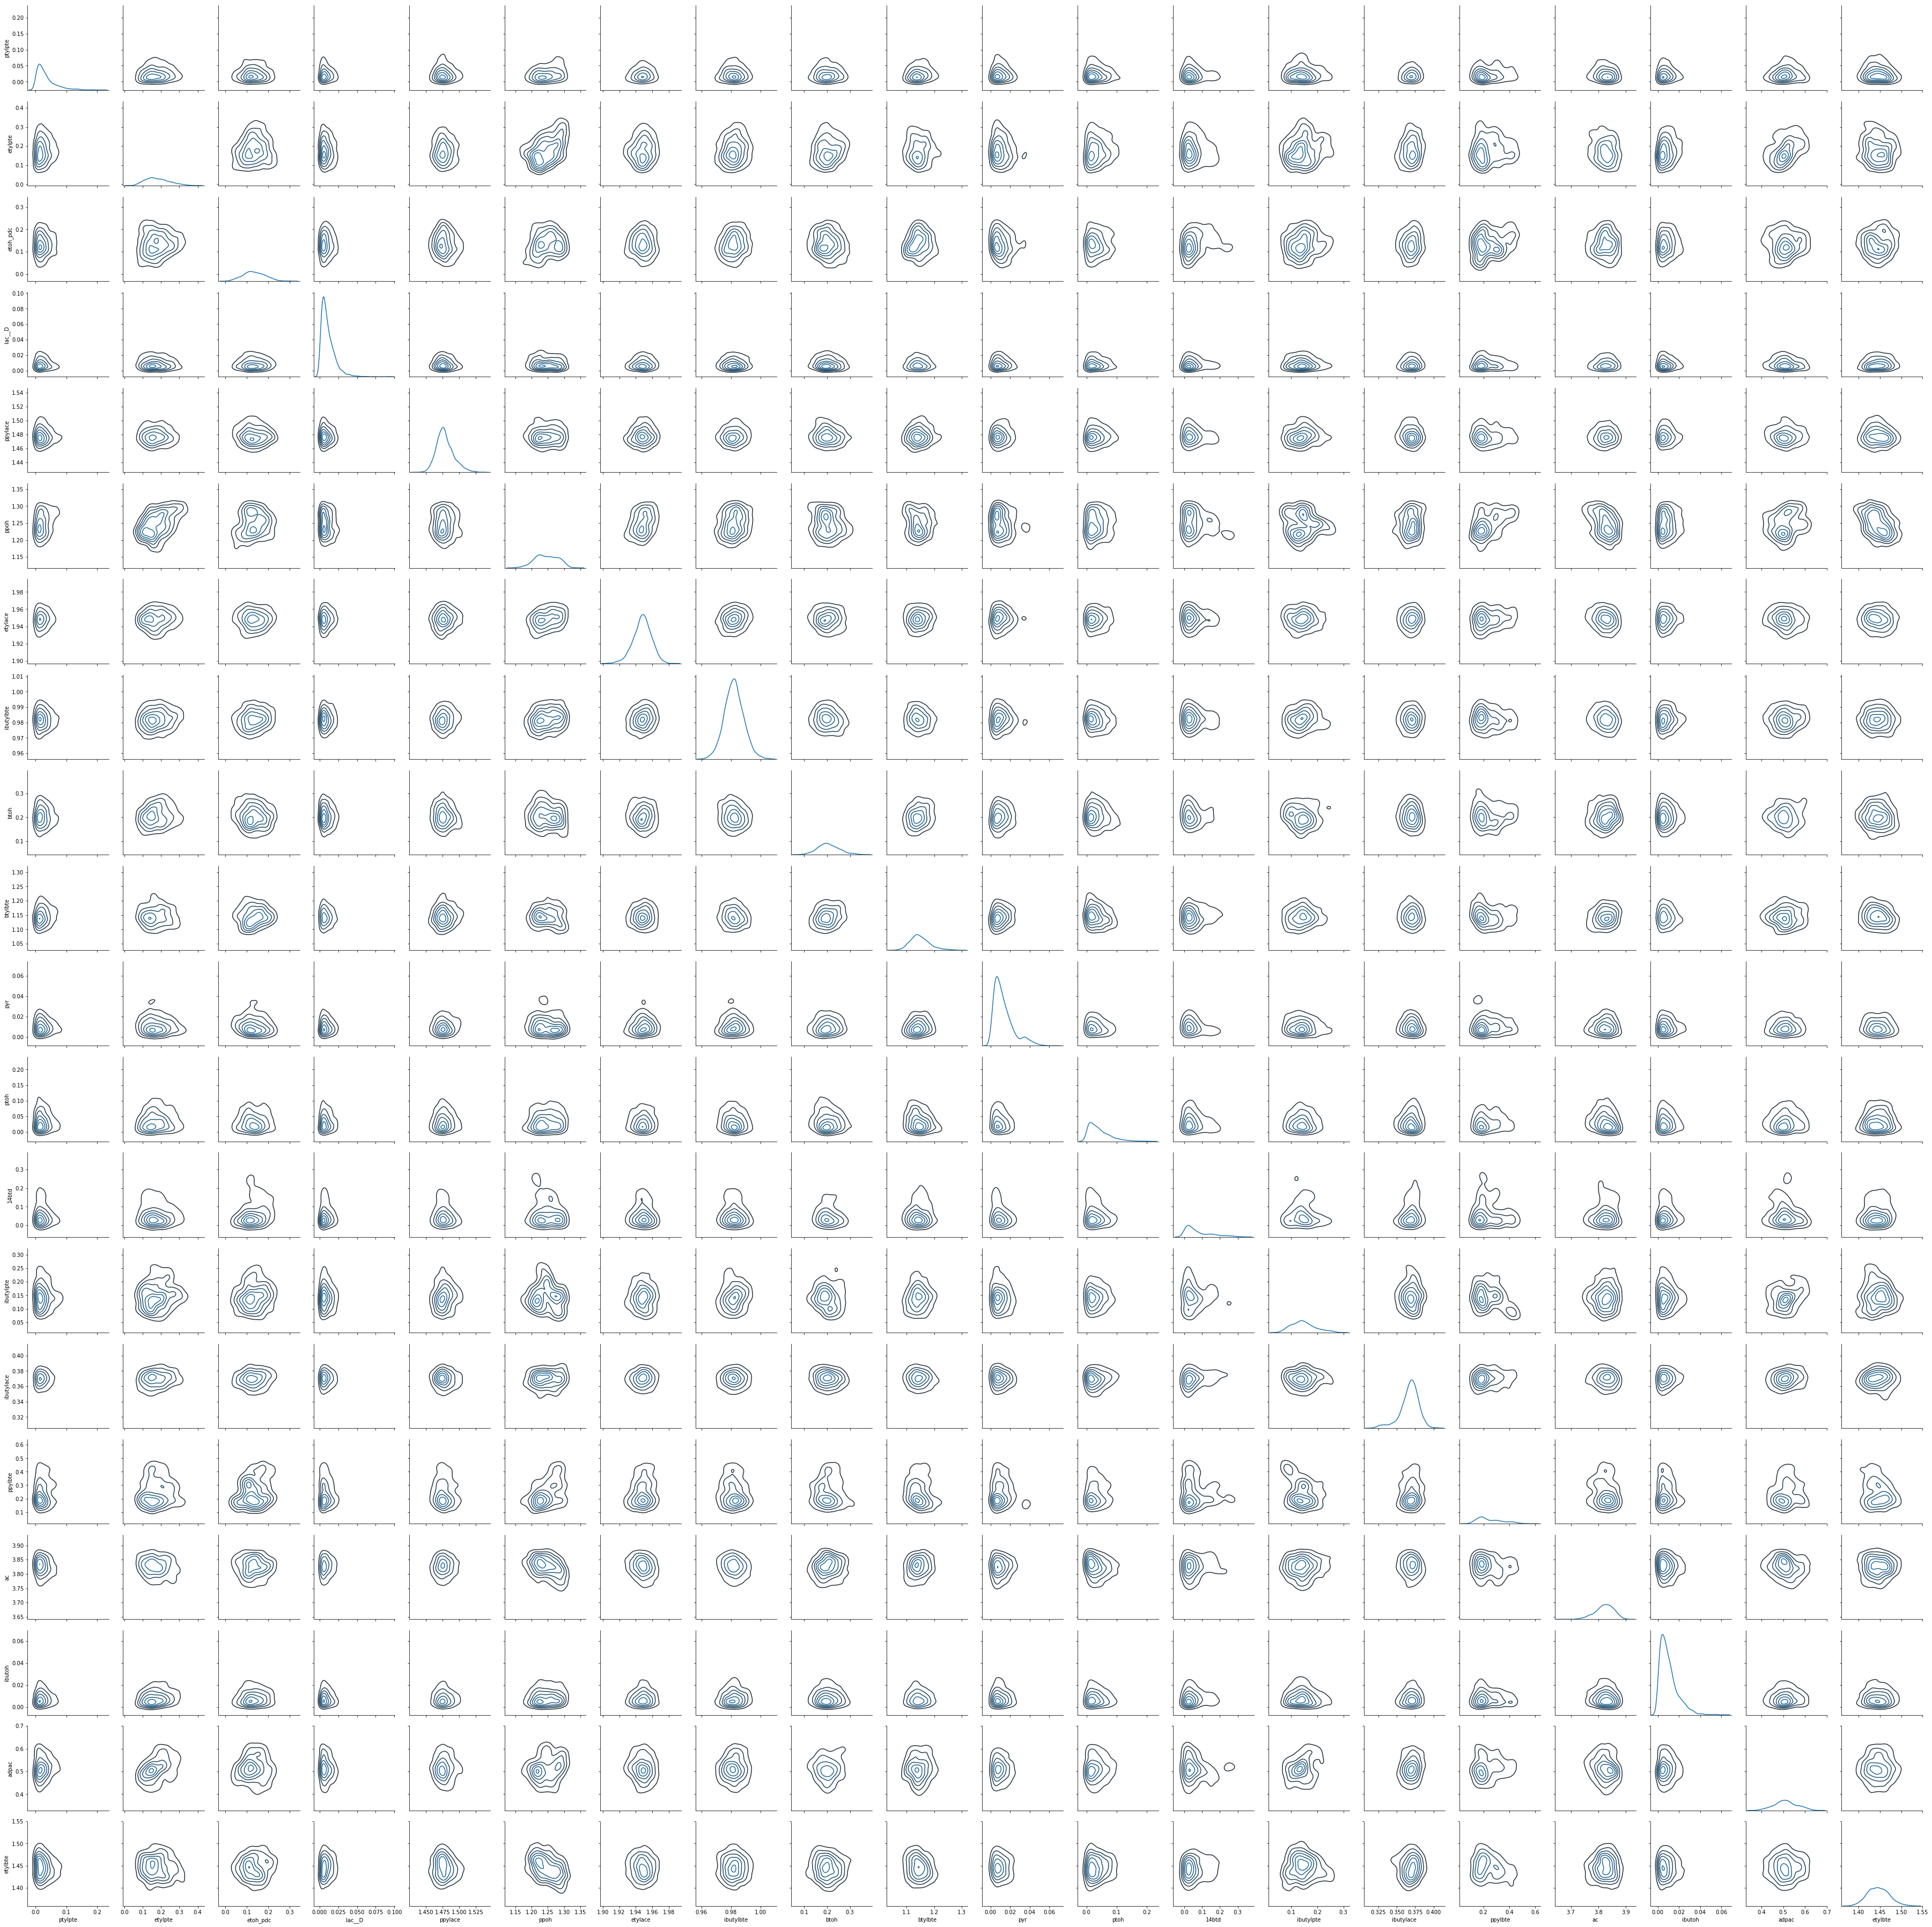

In [13]:
# Also checkout this: https://seaborn.pydata.org/tutorial/distributions.html
# To make a gird comparing key products
iris = pd.DataFrame(samples)
g = sns.PairGrid(iris)
g.map_diag(sns.kdeplot)
g.map_offdiag(sns.kdeplot, n_levels=6);